In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import gc
import time

from utils import *

PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/train_no_att_time.csv'),
 PosixPath('data/train_day7_3to16_nextclick.feather'),
 PosixPath('data/train_day8_3to16_FE.feather'),
 PosixPath('data/train_df_10mil_fe_v1.feather'),
 PosixPath('data/train_day8_3to16_nextclick.feather'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train_day9_3to16_FE.feather'),
 PosixPath('data/train_day9_3to16_nextclick.feather'),
 PosixPath('data/train_sample.csv'),
 PosixPath('data/train_day7_3to16_FE.feather'),
 PosixPath('data/val_df_10mil_fe_v1.feather'),
 PosixPath('data/mean_enc_df'),
 PosixPath('data/test.csv')]

In [2]:
def metric(rf,X_val,y_val):
    y_val_pred = rf.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val,y_val_pred)

def permutation_importances(rf,X_val,y_val,metric):
    baseline = metric(rf,X_val,y_val)
    imp=[]
    for col in X_val.columns:
        save = X_val[col].copy()
        X_val[col] = np.random.permutation(X_val[col])
        m = metric(rf,X_val,y_val)
        print(f'Score after {col} perm: {m:.5f}')
        X_val[col] = save
        imp.append(baseline-m)
    return np.array(imp)

def get_sample(filename,sz):
    df = get_feather(filename)
    sample_idx =np.random.permutation(df.shape[0])
    sample_idx=sorted(sample_idx[:sz])
    df = df.loc[sample_idx,:].reset_index().drop('index',axis=1)
    gc.collect()
    return df

In [31]:
def prediction_score(rf,train_df,y_train,val_df,y_val):
    y_train_pred = rf.predict_proba(train_df)[:,1]
    print(f'Train AUC: {roc_auc_score(y_train, y_train_pred)}')
    y_val_pred = rf.predict_proba(val_df)[:,1]
    print(f'Val AUC: {roc_auc_score(y_val, y_val_pred)}')

# Get data


In [4]:
train_df=get_feather('train_day8_3to16_FE.feather')

In [22]:
def get_sample(filename,sz):
    df = get_feather(filename)
    sample_idx =np.random.permutation(df.shape[0])
    sample_idx=sorted(sample_idx[:sz])
    df = df.loc[sample_idx,:].reset_index().drop('index',axis=1)
    gc.collect()
    return df

In [6]:
# sample_idx =np.random.permutation(train_df.shape[0])

# sz = 3000000
# sample_idx=sorted(sample_idx[:sz])

# train_df = train_df.loc[sample_idx,:].reset_index().drop('index',axis=1)

In [17]:
train_df.is_attributed.mean()

0.0024953333333333333

In [21]:
gc.collect()

117

In [18]:
val_df=get_feather('train_day9_3to16_FE.feather')

In [26]:
val_df.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour',
       'os_device_mean_target_day8_alpha1', 'ip_mean_target_day8_alpha1',
       'device_mean_target_day8_alpha1', 'app_channel_mean_target_day8_alpha1',
       'app_os_mean_target_day8_alpha1',
       'channel_device_mean_target_day8_alpha1', 'app_mean_target_day8_alpha1',
       'channel_os_mean_target_day8_alpha1',
       'app_device_mean_target_day8_alpha1', 'channel_mean_target_day8_alpha1',
       'ip_next_click', 'ip_app_next_click', 'ip_channel_next_click',
       'ip_os_cumcount', 'ip_app_cumcount', 'ip_device_os_app_cumcount',
       'ip_cumcount', 'ip_app_os_count_channel',
       'ip_app_day_hour_count_channel', 'app_AvgViewPerDistinct_ip',
       'ip_count_channel', 'app_count_channel', 'channel_count_app',
       'ip_device_os_size_None', 'ip_device_os_app_size_None', 'minute',
       'second'],
      dtype='object')

In [20]:
# sample_idx =np.random.permutation(val_df.shape[0])

# sz = 20000000
# sample_idx=sorted(sample_idx[:sz])

# val_df = val_df.loc[sample_idx,:].reset_index().drop('index',axis=1)

In [27]:
y_train = train_df.is_attributed
train_df.drop(['is_attributed','ip'],axis=1,inplace=True)

y_val = val_df.is_attributed
val_df.drop(['is_attributed','ip'],axis=1,inplace=True)
gc.collect()

95

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=10,max_features=.8,oob_score=False,
                           min_samples_leaf=10,n_jobs=-1,class_weight={1:100})

In [30]:
%%time
rf.fit(train_df,y_train)

CPU times: user 19min 23s, sys: 6 s, total: 19min 29s
Wall time: 5min 48s


RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=None, max_features=0.8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [32]:
prediction_score(rf,train_df,y_train,val_df,y_val)

Train AUC: 0.9997225077826053
Val AUC: 0.9005347330502085


Score after app perm: 0.90043
Score after device perm: 0.90108
Score after os perm: 0.90041
Score after channel perm: 0.90099
Score after day perm: 0.90053
Score after hour perm: 0.89953
Score after os_device_mean_target_day8_alpha1 perm: 0.90050
Score after ip_mean_target_day8_alpha1 perm: 0.90054
Score after device_mean_target_day8_alpha1 perm: 0.89886
Score after app_channel_mean_target_day8_alpha1 perm: 0.85685
Score after app_os_mean_target_day8_alpha1 perm: 0.89554
Score after channel_device_mean_target_day8_alpha1 perm: 0.87670
Score after app_mean_target_day8_alpha1 perm: 0.90261
Score after channel_os_mean_target_day8_alpha1 perm: 0.88322
Score after app_device_mean_target_day8_alpha1 perm: 0.90109
Score after channel_mean_target_day8_alpha1 perm: 0.86413
Score after ip_next_click perm: 0.89871
Score after ip_app_next_click perm: 0.90080
Score after ip_channel_next_click perm: 0.90001
Score after ip_os_cumcount perm: 0.89993
Score after ip_app_cumcount perm: 0.89672
Score afte

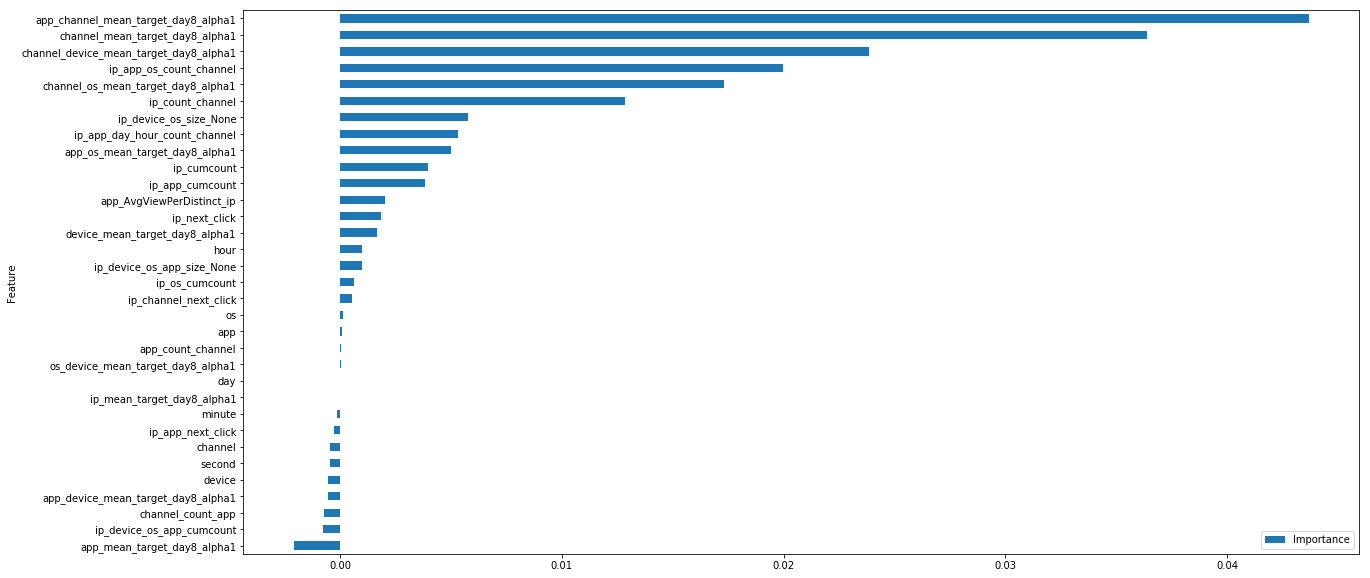

In [33]:
fea_imp = permutation_importances(rf,val_df,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':val_df.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
fea_imp_df.plot(kind='barh',figsize=(20,10))